## <a id='21'>Importing Packages</a>

In [1]:
# importing packages
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# importing packages for Plotly visualizations
import plotly
from plotly import graph_objs
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
plotly.offline.init_notebook_mode()

# import NLP packages
import multiprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer
from wordcloud import WordCloud
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

# import modeling packages
from sklearn import utils, svm
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

%reload_ext autoreload
%autoreload 2
import sys
# sys.path.append("py/")
from py.utils import *
from py.config import keys
from py.preprocess import *

ModuleNotFoundError: No module named 'cufflinks'

In [3]:
# import dataframe into notebook
df = pd.read_csv("data/original/labeled_data.csv", index_col=0)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
# get dimensions of dataframe
df.shape

(24783, 6)

In [5]:
# rename columns for easier reference
df = df.rename(columns={"hate_speech": 'hate', "offensive_language": 'offensive', "neither": 'neutral', "class": 'target'})
df.head()

,count,hate,offensive,neutral,target,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# <a id='3'>Data Understanding:</a>
<a href='#0'>Back to top</a>

In [6]:
# display class distribution
hate = len(df[df['target'] == 0])
off = len(df[df['target'] == 1])
neu = len(df[df['target'] == 2])
dist = [
    graph_objs.Bar(
        x=["hate", "offensive", "neutral"],
        y=[hate, off, neu],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Class Distribution")})

In [7]:
# create hate and non-hate categories by combining offensive and neutral categories
df.target = df.target.replace([2], 1)
df.target = df.target.replace([0, 1], [1, 0])
df.target.value_counts()

0    23353
1     1430
Name: target, dtype: int64

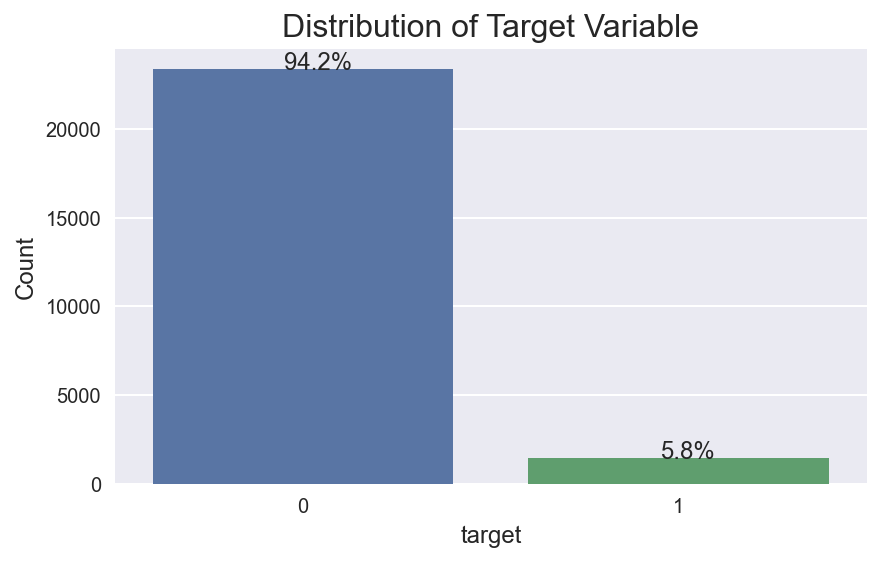

In [10]:
# create visualization for new target variable distribution
def barplot(df, feature, title):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.countplot(x=feature, data=df, ax=ax)
    plt.title(title, fontsize=16)
    plt.xlabel("target", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    total = len(df.target)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size=12)
    fig.show()
    fig.savefig("images/target_distribution.png")

plt.style.use('seaborn')
barplot(df, 'target', 'Distribution of Target Variable')

In [15]:
# display first few lines of tweet texts
df.tweet.head(20)

0     !!! RT @mayasolovely: As a woman you shouldn't...
1     !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2     !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3     !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5     !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6     !!!!!!"@__BrighterDays: I can not just sit up ...
7     !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8     " &amp; you might not get ya bitch back &amp; ...
9     " @rhythmixx_ :hobbies include: fighting Maria...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

## <a id='32'>Initial EDA</a>

### Word Count Per Tweet

In [16]:
# create functions to count number of words in tweet
def num_of_words(df, col):
    df['word_ct'] = df[col].apply(lambda x: len(str(x).split(" ")))
    print(df[[col, 'word_ct']].head())

num_of_words(df, 'tweet')

                                               tweet  word_ct
0  !!! RT @mayasolovely: As a woman you shouldn't...       25
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       16
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...       21
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        9
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...       26


In [17]:
# create visualization for word count distribution
df['word_ct'].iplot(
    kind='hist',
    bins=40,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution')

### Number of Characters Per Tweet

In [18]:
# create function to ccount number of characters in a tweet
def num_of_chars(df, col):
    df['char_ct'] = df[col].str.len()
    print(df[[col, 'char_ct']].head())

num_of_chars(df, 'tweet')

                                               tweet  char_ct
0  !!! RT @mayasolovely: As a woman you shouldn't...      140
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...       85
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      120
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...       62
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      137


In [19]:
# create visualization to display character count distribution
df['char_ct'].iplot(
    kind='hist',
    bins=100,
    xTitle='character count',
    linecolor='black',
    yTitle='count',
    title='Character Count Distribution')

### Average Word Length Per Tweet

In [20]:
# create function to calculate average word length and then average word length per tweet
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

def avg_word_length(df, col):
    df['avg_wrd'] = df[col].apply(lambda x: avg_word(x))
    print(df[[col, 'avg_wrd']].head())

avg_word_length(df, 'tweet')

                                               tweet   avg_wrd
0  !!! RT @mayasolovely: As a woman you shouldn't...  4.640000
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  4.375000
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  4.761905
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  6.000000
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  4.307692


In [21]:
# create visualization for average word length distribution
df['avg_wrd'].iplot(
    kind='hist',
    bins=60,
    xTitle='average word length',
    linecolor='black',
    yTitle='count',
    title='Average Word Length Distribution')

### Hashtags Count

In [22]:
# create function to count number of hashtags per tweet
def hash_ct(df, col):
    df['hash_ct'] = df[col].apply(lambda x: len(re.split(r'#', str(x)))-1)
    print(df[[col, 'hash_ct']].head())

hash_ct(df, 'tweet')

                                               tweet  hash_ct
0  !!! RT @mayasolovely: As a woman you shouldn't...        0
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...        0
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...        0
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...        0
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...        1


In [23]:
# create visualization for displaying hashtag distribution 
df['hash_ct'].iplot(
    kind='hist',
    bins=100,
    xTitle='hashtags count',
    linecolor='black',
    yTitle='count',
    title='Number of Hashtags Distribution')

## <a id='33'>Data Preprocessing:</a>

What are the challenges in dealing with tweets:

1. Inconsistent use of grammar, proper spelling, punctuation, and capitalization
2. Repetition of same ch1aracter, and use of random abbreviations makes tokenization and POS tagging difficult
3. Use of special characters, i.e. emojis, emoticons, hashtags


Here I have defined the techniques used in preprocessing tweets:

- **Letter casing:** Converting all letters to either upper case or lower case.
- **Tokenizing:** Separating piece of text into tokens most often into individual words based on the separating spaces as delimiter, but can be performed on the word, character or subword level
- **Noise removal:**
    - Eliminating unwanted characters, such as HTML tags, punctuation marks, special characters, white spaces, etc.
- **Stopword removal:**
    - Some words do not contribute much to the machine learning model, so it's good to remove them. 
    - A list of stopwords can be defined by the nltk library, or it can be business-specific.
- **Normalization:**
    - Generally refers to a series of related tasks meant to put all text on the same level
    - Converting text to lower case, removing special characters, and removing stopwords will remove basic inconsistencies
    - improves text matching
- **Stemming or Lemmatization:**
    - Eliminating affixes (circumfixes, suffixes, prefixes, infixes) from word in order to obtain word stem and generally chops off end of words, where Porter Stemmer is the most widely used technique 
    - Goal is same as with stemming, but while stemming can cause loss of actual meaning of word
    - returns base or dictionary form of word, also known as lemma
- **Vectorization:**
    - process of converting tokens to numbers since machine learning algorithm works with numbers and not text
    - such as vectorization using tf-idf, or Bag of Words and N-grams

Since there is so much colloquial use of words amongst tweets, we did not anticipate that stemming or lemmatization to have a significant impact on the predictive value of the model. 

In [27]:
preprocess_tweets(df, 'tweet')
df.head()

,count,hate,offensive,neutral,target,tweet,word_ct,char_ct,avg_wrd,hash_ct
0,3,0,0,3,0,woman shouldnt complain clean house man trash,25,140,4.640000,0
1,3,0,3,0,0,,16,85,4.375000,0
2,3,0,3,0,0,dawg fuck bitch start confuse shit,21,120,4.761905,0
3,3,0,2,1,0,,9,62,6.000000,0
4,6,0,6,0,0,shit hear true faker bitch tell,26,137,4.307692,1


Here is the thought process involved with each of the specific steps we identified working with the dataset to prepare the data for the modeling process:

- We removed callouts or usernames, which is preceded by @.  They contain no useful information.
- We removed character references, which includes HTML character references, but also emojis, unicode characters. We decided not to convert any emojis into sentiment words.
- We removed the hash from the hashtags and decided to keep the hashtag text because they are often words or word-like and are used to connect similar ideas across the platform.  We could analyze the hashtags in a future project.
- We removed the Twitter codes RT and QT for retweet and quotetweet.  We decided to keep the retweeted words, as it conveys important information while others have removed all the text after RT.
- We removed the HTML links since a lot of users link a website reference as part of the tweet.
- We then removed any punctuation. We did not convert contractions into the uncontracted words.
- We then lowercased all the tweets for tokenizing.
- We removed any numbers and number containing words for tokenization and vectorizing.
- We removed any extra whitespace(s) between words and any leading and trailing whitespaces.

Additional steps before modeling includes stopword removal, tokenization, lemmatizing, stemming, and/or vectorizing.

In [56]:
# display first five rows of dataframe
df.head()

,count,hate,offensive,neutral,target,tweet,word_ct,char_ct,avg_wrd,hash_ct,tokenized
0,3,0,0,3,0,"[woman, shouldnt, complain, clean, house, man,...",25,140,4.640000,0,woman shouldnt complain clean house man trash
1,3,0,3,0,0,"[boy, dats, coldtyga, dwn, bad, cuffin, dat, h...",16,85,4.375000,0,boy dats coldtyga dwn bad cuffin dat hoe place
2,3,0,3,0,0,"[dawg, fuck, bitch, start, confuse, shit]",21,120,4.761905,0,dawg fuck bitch start confuse shit
3,3,0,2,1,0,"[look, like, tranny]",9,62,6.000000,0,look like tranny
4,6,0,6,0,0,"[shit, hear, true, faker, bitch, tell]",26,137,4.307692,1,shit hear true faker bitch tell


## <a id='34'>Train-Validation-Test Split</a>

In [57]:
# separate dataframe into respective classes
hate = df[df.target == 1]
non_hate = df[df.target == 0]

In [58]:
# separate features from target variable for train_test_splt
X_h = hate.tweet
y_h = hate.target
X_nh = non_hate.tweet
y_nh = non_hate.target

# perform 75-25 training-validation split and 15-10 validation-testing split on dataset
X_h_tr, X_h_val, y_h_tr, y_h_val = train_test_split(X_h, y_h, test_size=0.25, random_state=42)
X_h_val, X_h_tt, y_h_val, y_h_tt = train_test_split(X_h_val, y_h_val, test_size=0.4, random_state=42)
X_nh_tr, X_nh_val, y_nh_tr, y_nh_val = train_test_split(X_nh, y_nh, test_size=0.25, random_state=42)
X_nh_val, X_nh_tt, y_nh_val, y_nh_tt = train_test_split(X_nh_val, y_nh_val, test_size=0.4, random_state=42)

In [59]:
# concatenate hate and non-hate dataframe to reform entire training dataset
X_tr = pd.concat((X_h_tr, X_nh_tr), ignore_index=True)
y_tr = pd.concat((y_h_tr, y_nh_tr), ignore_index=True)
train = pd.concat([X_tr, y_tr], axis=1)

# # remove brackets around the list to create a list of strings
train['tweet2'] = train.tweet.apply(lambda x: str(x)[1:-1]) 
train.head()

,tweet,target,tweet2
0,"[reject, constantly, house, threaten, rape, mo...",1,"'reject', 'constantly', 'house', 'threaten', '..."
1,"[convince, lame, nigger, liver, believe, cuz, ...",1,"'convince', 'lame', 'nigger', 'liver', 'believ..."
2,"[peace, fag, remember, best, lux, support, dro...",1,"'peace', 'fag', 'remember', 'best', 'lux', 'su..."
3,"[haha, ight, nig, calm, yoself]",1,"'haha', 'ight', 'nig', 'calm', 'yoself'"
4,"[tits, better, look, face, make, like, asian, ...",1,"'tits', 'better', 'look', 'face', 'make', 'lik..."


In [60]:
# concatenate hate and non-hate dataframes to reform entire validation dataset
X_val = pd.concat((X_h_val, X_nh_val), ignore_index=True)
y_val = pd.concat((y_h_val, y_nh_val), ignore_index=True)
val = pd.concat([X_val, y_val], axis=1)

# remove brackets around the list to create a list of string
val['tweet2'] = val.tweet.apply(lambda x: str(x)[1:-1]) 
val.head()

,tweet,target,tweet2
0,"[lbum, fotos, gaywrites, make, project, queer,...",1,"'lbum', 'fotos', 'gaywrites', 'make', 'project..."
1,"[yay, america, israel, jew, hat, muslim, trash...",1,"'yay', 'america', 'israel', 'jew', 'hat', 'mus..."
2,"[miss, ofay, friends, day, scar, recent, happe...",1,"'miss', 'ofay', 'friends', 'day', 'scar', 'rec..."
3,"[trash, darkskin, nigga, steal, damn, garbage]",1,"'trash', 'darkskin', 'nigga', 'steal', 'damn',..."
4,"[cody, call, people, nigger, hes, fuck, spaz]",1,"'cody', 'call', 'people', 'nigger', 'hes', 'fu..."


In [61]:
X_tt = pd.concat((X_h_tt, X_nh_tt), ignore_index=True)
y_tt = pd.concat((y_h_tt, y_nh_tt), ignore_index=True)
test = pd.concat([X_tt, y_tt], axis=1)

# remove brackets around the list to create a list of string
test['tweet2'] = test.tweet.apply(lambda x: str(x)[1:-1]) 
test.head()

,tweet,target,tweet2
0,"[johnny, rebel, nigger, day]",1,"'johnny', 'rebel', 'nigger', 'day'"
1,"[favorite, nigger, work, plantation, remember,...",1,"'favorite', 'nigger', 'work', 'plantation', 'r..."
2,"[go, prestigious, establishments, clearly, sup...",1,"'go', 'prestigious', 'establishments', 'clearl..."
3,"[westvirginia, white, trash]",1,"'westvirginia', 'white', 'trash'"
4,"[fuck, brett, farve, redneck, ass, stuckup, do...",1,"'fuck', 'brett', 'farve', 'redneck', 'ass', 's..."


## <a id='35'>More EDA</a>

### Frequency Distributions

In [62]:
# split back into minority and majority classes for visualizations
zero = train[train.target == 0]
one = train[train.target == 1]

In [63]:
# create list of tokens for 
zero_tokens = []
for index, row in zero.iterrows():
    zero_tokens.extend(row['tweet'])

one_tokens = []
for index, row in one.iterrows():
    one_tokens.extend(row['tweet'])

In [49]:
# convert collection of text documents to matrix of token counts
vec = CountVectorizer()

# learn vocabulary dictionary to return document-term matrix
docs = vec.fit_transform(zero_tokens)

# array mapping from feature integer indices to feature name
features = vec.get_feature_names()

# use Yellowbrick implementation of visualizing token frequency distribution
visualizer = FreqDistVisualizer(features=features, orient='h', n=25, size=(540, 360), color='tab:blue')
visualizer.fit(docs)
custom_viz = visualizer.ax
custom_viz.set_xlabel('Number of Tokens', fontsize=14)
custom_viz.set_ylabel('Token', fontsize=14)
custom_viz.set_title("Frequency Distribution of Top 25 Tokens for Non-Hate Tweets", fontsize=14)
custom_viz.figure.show()

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [99]:
custom_viz.figure.savefig("images/freq_dist_zero.png")

Some of the top phrases in the negative class are: 'bitch', 'hoe', 'pussy', 'fuck', 'nigga'.  'Bitch' , 'fuck', and 'nigga' are 'Hoe' and 'pussy' appears in less frequency in the positive class.  

Notably, 'nigger', 'white', 'trash', 'retard', 'queer', 'gay', 'fag' and 'faggot' are almost exclusively in the positive class.

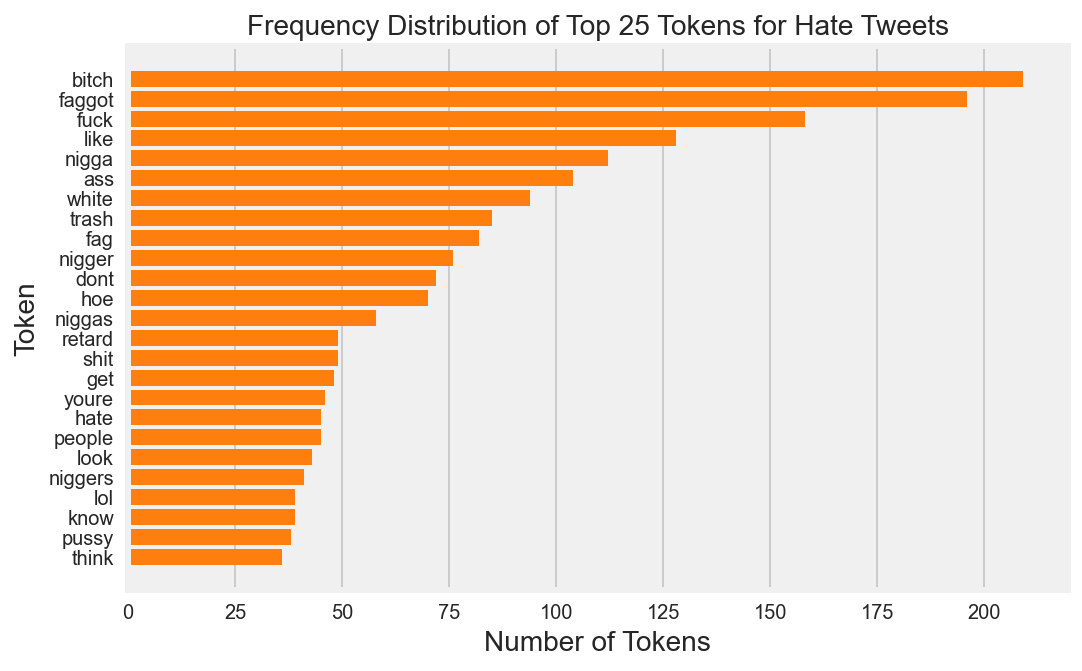

In [96]:
# create visualization for positive class
vec_one = CountVectorizer()
docs_one = vec_one.fit_transform(one_tokens)
features_one = vec_one.get_feature_names()

visualizer_one = FreqDistVisualizer(features=features_one, orient='h', n=25, size=(540, 360), color='tab:orange')
visualizer_one.fit(docs_one)
custom_viz_one = visualizer_one.ax
custom_viz_one.set_xlabel('Number of Tokens', fontsize=14) 
custom_viz_one.set_ylabel('Token', fontsize=14)
custom_viz_one.set_title("Frequency Distribution of Top 25 Tokens for Hate Tweets", fontsize=14)
custom_viz_one.figure.show()

In [97]:
custom_viz_one.figure.savefig("images/freq_dist_one.png")

### t-SNE Corpus Visualization

<AxesSubplot:title={'center':'TSNE Projection of 18586 Documents'}>

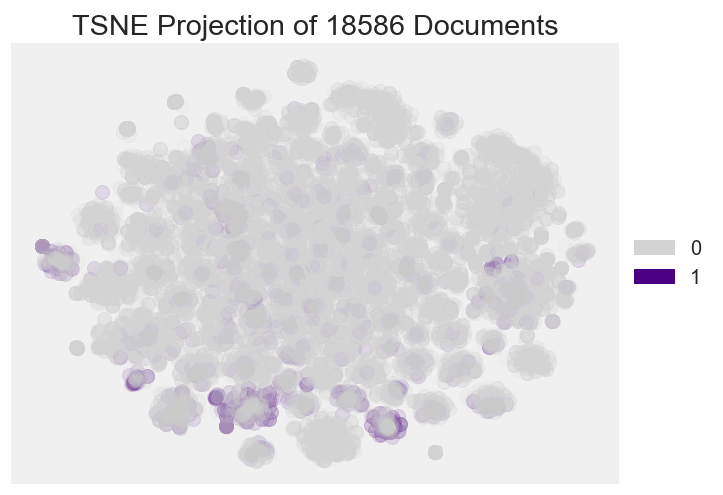

In [105]:
# create TSNE visualization for negative class
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train.tweet2)
y = train.target

visualizer = TSNEVisualizer(alpha=0.1, colors=['lightgray', 'indigo'], decompose='svd', decompose_by=100, random_state=42)
visualizer.fit(X, y)
visualizer.show(outpath="images/tsne.png")

<AxesSubplot:title={'center':'TSNE Projection of 17514 Documents'}>

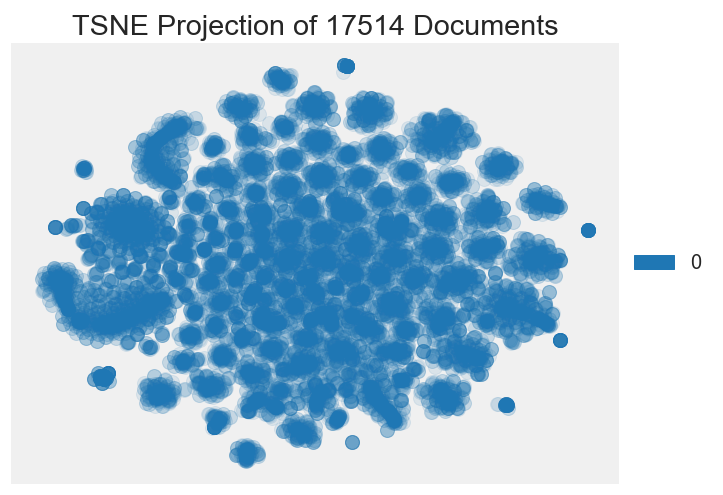

In [106]:
# create TSNE visualization for negative class
tfidf = TfidfVectorizer()
X_zero = tfidf.fit_transform(zero.tweet2)
y_zero = zero.target

visualizer = TSNEVisualizer(alpha=0.1, colors=['tab:blue'], decompose='svd', decompose_by=100, random_state=42)
visualizer.fit(X_zero, y_zero)
visualizer.show(outpath="images/tsne_zero.png")

<AxesSubplot:title={'center':'TSNE Projection of 1072 Documents'}>

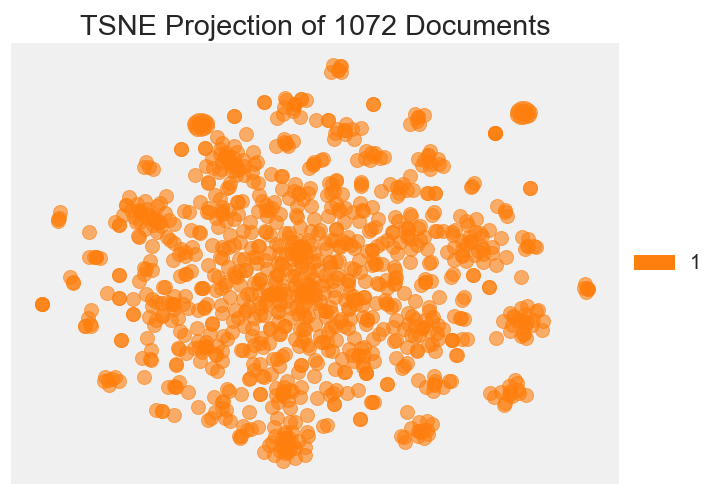

In [107]:
# create TSNE visualization for negative class
tfidf = TfidfVectorizer()
X_one = tfidf.fit_transform(one.tweet2)
y_one = one.target

visualizer = TSNEVisualizer(alpha=0.6, decompose='svd', colors=['tab:orange'], decompose_by=100, random_state=42)
visualizer.fit(X_one, y_one)
visualizer.show(outpath="images/tsne_one.png")

There is still strong overlap between the two classes as evinced by the diagrams. But there are clusters at the extremes (topmost, bottommost, far left, far right) that appear in the minority class TSNE that does not seem to appear in the majoity class.

### Wordcloud

(-0.5, 399.5, 199.5, -0.5)

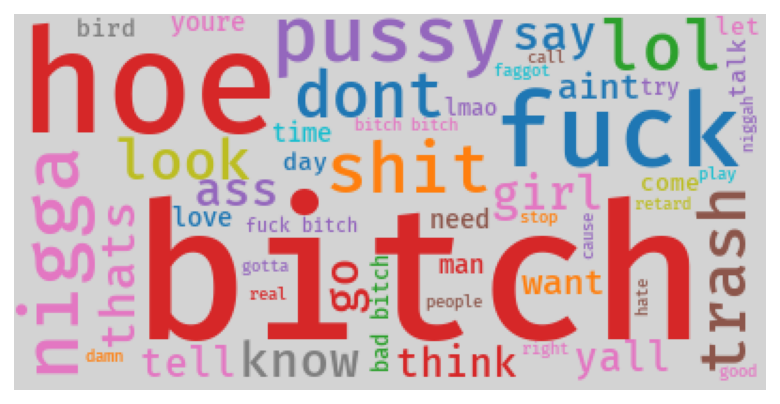

In [72]:
text = ' '.join(zero_tokens)

# Initialize wordcloud object
wc = WordCloud(font_path="/Users/examsherpa/Library/Fonts/FiraMono-Medium.ttf", background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

(-0.5, 399.5, 199.5, -0.5)

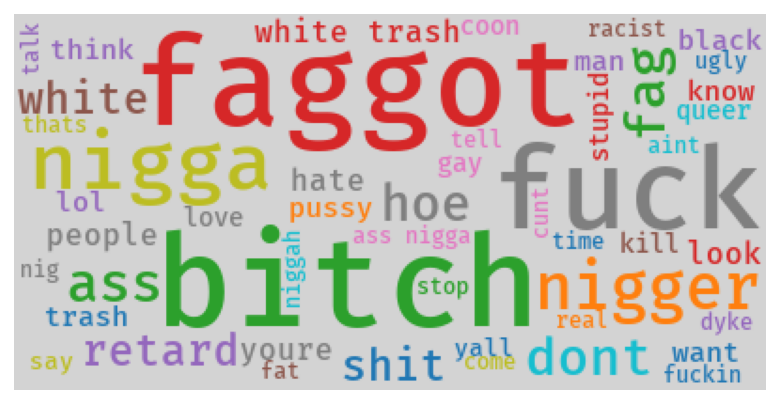

In [73]:
text = ' '.join(one_tokens)

# Initialize wordcloud object
wc = WordCloud(font_path="/Users/examsherpa/Library/Fonts/FiraMono-Medium.ttf", background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

The traditional epithets are not found in exclusively in the hate category, only the less traditional words often in the form of hashtags can be found exclusively as hate speech.  That would make sense. in terms pf

- sexual orientation:  teabagged, girlboy, azflooding, azmonsoon, molester, cousintoucher, theyfaggots, dicklicker
- sex:  wenchs
- race/ethnicity/religion:  osamas, spicskkk, niggerous, nigglets. nigress, ovenjew, westvirginia, texarkana, ching, chong, maoists, mexicannigger

One clear distinction is the difference in use of nigga versus the n word.  When people say the f word against homosexuals, it is more often in the derogatory sense.  The p word can be just offensive or sexist, i.e. males use the p word to denigrate guys, which can be offensive but not considered hate speech. 

# <a id='4'>Modeling Process:</a>
<a href='#0'>Back to top</a>

In [34]:
train.tweet2

0        'reject', 'constantly', 'house', 'threaten', '...
1        'convince', 'lame', 'nigger', 'liver', 'believ...
2        'peace', 'fag', 'remember', 'best', 'lux', 'su...
3                  'haha', 'ight', 'nig', 'calm', 'yoself'
4        'tits', 'better', 'look', 'face', 'make', 'lik...
                               ...                        
18581                               'miss', 'lil', 'bitch'
18582    'gotta', 'hoe', 'smh', 'aint', 'captain', 'sav...
18583        'lmao', 'yeah', 'bitch', 'lil', 'shit', 'rip'
18584                                'tbt', 'bad', 'bitch'
18585                  'hoe', 'act', 'know', 'imma', 'let'
Name: tweet2, Length: 18586, dtype: object

In [35]:
# assign feature and target variables
X_tr = train.tweet2
X_val = val.tweet2
y_tr = train.target
y_val = val.target

# vectorize tweets for modeling
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

## Multinomial Naive Bayes

Accuracy:  0.9426957223567393
F1 Score:  0.009302325581395347
ROC-AUC:  0.7177479383492388
Recall:  0.004672897196261682
Precision:  1.0
PR-AUC:  0.17675788857212738


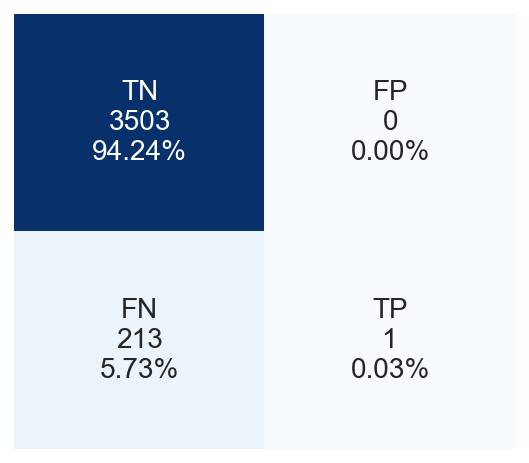

In [47]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pred_nb = nb.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_nb, nb)


## Random Forest

Accuracy:  0.9429647565240785
F1 Score:  0.17829457364341086
ROC-AUC:  0.8341601724556521
Recall:  0.10747663551401869
Precision:  0.5227272727272727
PR-AUC:  0.3320729281556375


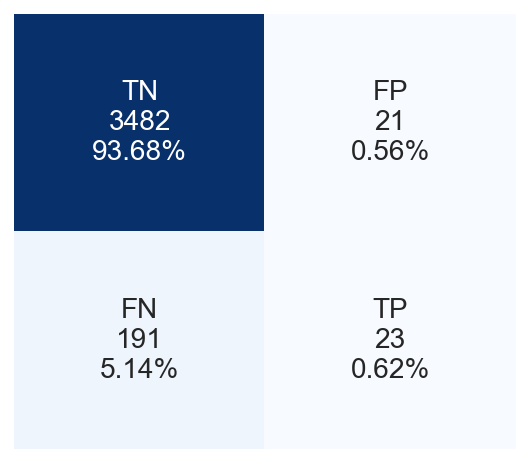

In [48]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pred_rf = rf.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_rf, rf)

## Logistic Regression

Accuracy:  0.9443099273607748
F1 Score:  0.20077220077220076
ROC-AUC:  0.8743293465414158
Recall:  0.12149532710280374
Precision:  0.5777777777777777
PR-AUC:  0.355640424831512


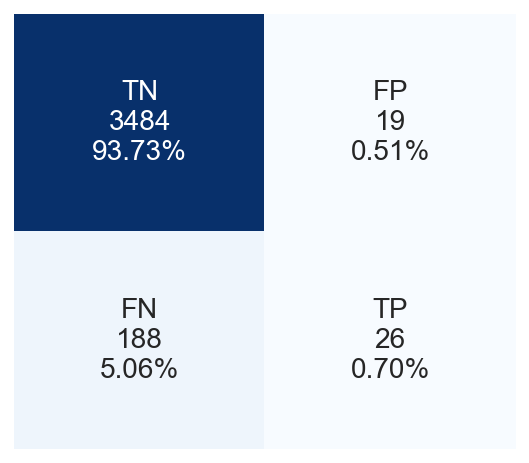

In [49]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pred_log = log.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_log, log)

## Support Vector Machine

In [50]:
svc = svm.LinearSVC(random_state=42).fit(tfidf_tr, y_tr)
y_pred_svc = svc.predict(tfidf_val)
get_metrics_2(tfidf_val, y_val, y_pred_svc, svc)

Accuracy:  0.9391982781813291
F1:  0.2709677419354839
Recall:  0.19626168224299065
Precision:  0.4375
PR-AUC:  0.32508683821796447


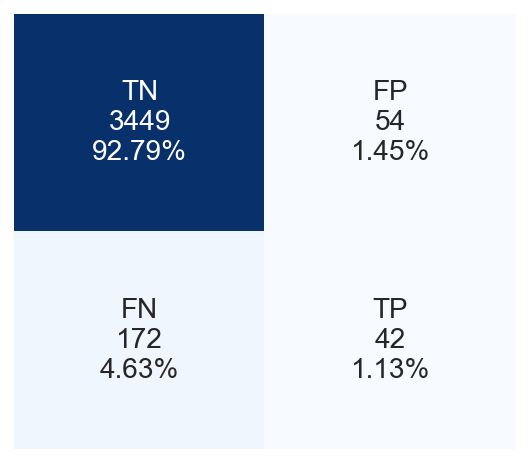

In [51]:
get_confusion(y_val, y_pred_svc)

## Adaboost

Accuracy:  0.9408124831853646
F1 Score:  0.27152317880794696
ROC-AUC:  0.8074267450329624
Recall:  0.19158878504672897
Precision:  0.4659090909090909
PR-AUC:  0.2970758953330604


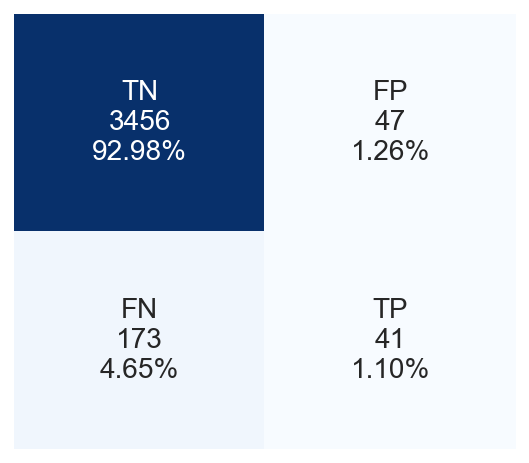

In [52]:
abc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
    ).fit(tfidf_tr, y_tr)
y_pred_abc = abc.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_abc, abc)

## Gradient Boosting

Accuracy:  0.9424266881894
F1 Score:  0.17054263565891473
ROC-AUC:  0.8384542221487056
Recall:  0.102803738317757
Precision:  0.5
PR-AUC:  0.34600315497228307


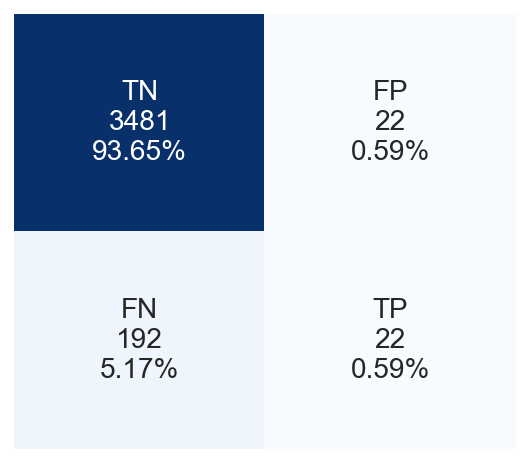

In [53]:
gbc = GradientBoostingClassifier().fit(tfidf_tr, y_tr)
y_pred_gbc = gbc.predict(tfidf_val)
get_metrics_confusion(tfidf_val, y_val, y_pred_gbc, gbc)

In [44]:
# display metrics from training
metrics = pd.read_csv("data/metrics/metrics.csv", index_col=0)
metrics

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR-AUC
Multinomial Naive Bayes,0.942696,0.009302,0.004673,1.000000,0.717748,0.176758
Random Forest,0.941620,0.168582,0.102804,0.468085,0.842541,0.321484
Logistic Regression,0.944310,0.200772,0.121495,0.577778,0.874329,0.355640
Support Vector Machine,0.939198,0.270968,0.196262,0.437500,0.836493,0.325087
AdaBoost Classifier,0.940543,0.270627,0.191589,0.460674,0.814550,0.297494
Gradient Boosting Classifier,0.942965,0.184615,0.112150,0.521739,0.838608,0.349449


### Analysis:

The accuracy score is misleading here since 94.2 percent of the dataset is in the majority class. 

So Random Forest, Support Vector Machine, and Adaboost performed worse in terms of assigning the majority class than a model assigning every single member in the dataset as the majority class, which would have an accuracy of 94.2.

# <a id='5'>Class Imbalance</a>

<a href='#0'>Back to top</a>

## <a id='51'>Resampling Methods</a>

I picked an undersampling, oversampling, and combined resampling method to address the class imbalance:

1. Random Under Sampler
2. Condensed Nearest Neighbor
3. SMOTE-ENN



### Random Under Sampler

The baseline population for the majority and minority classes is 17514 and 1072, respectively. Random Under Sampling undersampled the majority class randomly until the two classes are equal in number, essentially 1072 for each.

For the modeling process, there are 1072 instances of the majority and minority classes.

In [68]:
# display metrics for training after applying RUS
metrics2 = pd.read_csv("data/metrics/metrics2.csv", index_col=0)
metrics2

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR-AUC
RUS Multinomial Naive Bayes,0.710519,0.240113,0.794393,0.141431,0.838390,0.329976
RUS Random Forest,0.814904,0.318812,0.752336,0.202261,0.859188,0.315360
RUS Logistic Regression,0.824052,0.332653,0.761682,0.212794,0.865465,0.331852
RUS Support Vector Machine,0.787732,0.288548,0.747664,0.178771,0.848584,0.309002
RUS AdaBoost Classifier,0.768362,0.267234,0.733645,0.163371,0.814391,0.266228
RUS Gradient Boosting Classifier,0.841808,0.331818,0.682243,0.219219,0.849260,0.328457


### Condensed Nearest Neighbor

CNN undersamples the majority class by keeping only instances from the majority class that cannot be classified using the KNN algorithm.  An odd number is ideal to use since classification is determined by majority vote.  It keeps all members of the minority class. It results in 1239 instances of the majority and 1072 instances of the minority class.

In [69]:
# display metrics from training after applying CNN
metrics3 = pd.read_csv("data/metrics/metrics3.csv", index_col=0)
metrics3

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR-AUC
CNN Multinomial Naive Bayes,0.869518,0.323570,0.542056,0.230616,0.796428,0.271775
CNN Random Forest,0.887006,0.371257,0.579439,0.273128,0.833921,0.301401
CNN Logistic Regression,0.891579,0.386606,0.593458,0.286682,0.861070,0.319381
CNN Support Vector Machine,0.844767,0.317160,0.626168,0.212361,0.826500,0.252725
CNN AdaBoost Classifier,0.813021,0.278297,0.626168,0.178905,0.781618,0.187342
CNN Gradient Boosting Classifier,0.890772,0.381098,0.584112,0.282805,0.842994,0.293065


### SMOTE-ENN

This tecchnique combines the benefits of oversampling with SMOTE with undersampling with ENN.  ENN (Edited Nearest Neighbor) finds the K-nearest neighbor of each observation and compares the majority class from nearest neighbor to the observation.  When they differ, both the observation and the K-nearest neighbor are removed. SMOTE (Synthetic Minority Oversampling Technique) is an oversampling method that generates synthetic minority instances by interpolating them between two minority classes that are nearest neighbors.

In [70]:
# display metrics from training after running SMOTE-ENN
metrics4 = pd.read_csv("data/metrics/metrics4.csv", index_col=0)
metrics4

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR-AUC
Sm-ENN Multinomial Naive Bayes,0.793113,0.269706,0.663551,0.169249,0.797770,0.296334
Sm-ENNR andom Forest,0.929244,0.427015,0.457944,0.400000,0.865129,0.327962
Sm-ENN Logistic Regression,0.793113,0.269706,0.663551,0.169249,0.854613,0.317006
Sm-ENN Support Vector Machine,0.887813,0.355487,0.537383,0.265589,0.823857,0.294173
Sm-ENN AdaBoost Classifier,0.882432,0.360176,0.574766,0.262260,0.842466,0.298775
Sm-ENN Gradient Boosting Classifier,0.887006,0.376855,0.593458,0.276087,0.849248,0.325147


## <a id='52'>Incorporating Additional Minority Class Instances</a>

### Aristotle University Dataset

This goal of this work was to create a large and accurate dataset of tweets annotated using a crowdsourcing platform such as CrowdFlower by creating multiple labels of abusive behavior to study the correlation between them and make adjustments (keep or eliminate) based on the correlations.

The categories they settled on are abusive and hateful. Abusive language as per their definition is any strongly impolite, rude, or hurtful language using profanity, that can show a debasement of someone or something, or show intense emotion. Hate speech is defined as language used to express hatred towards a targeted individual or group, or is intended to be derogatory, to humiliate, or to insult the members of the group, on the basis of attributes such as race, religion, ethnic origin, sexual orientation, disability, or gender.

The dataset contains 79996 tweets, where 3635 were categorized as hate speech.

In [38]:
# upload dataset
df = pd.read_csv('data/original/hatespeechtwitter.csv')
df.head()

,tweet_id,maj_label
0,849667487180259329,abusive
1,850490912954351616,abusive
2,848791766853668864,abusive
3,848306464892604416,abusive
4,850010509969465344,normal


In [39]:
# get value counts for target variable categories
df.columns = ['id', 'label']
df.label.value_counts()

normal     52835
spam       13404
abusive    10122
hateful     3635
Name: label, dtype: int64

### Using Twitter API

In [40]:
# get tweet IDs into form to insert into API
df_hateful = df[df['label']=='hateful']
hate_ids = group_list(list(df_hateful.id))
len(hate_ids)

37

In [41]:
# setup url and headers for calling Twitter API as per documentation
url = "https://api.twitter.com/2/tweets?ids=847661947159891972,847799130277675008,848933211375779840&tweet.fields=created_at,entities,geo,id,public_metrics,text&user.fields=description,entities,id,location,name,public_metrics,username"
payload={}
headers = {'Authorization': 'Bearer ' + keys['bearer_token'], 'Cookie': 'personalization_id="v1_hzpv7qXpjB6CteyAHDWYQQ=="; guest_id=v1%3A161498381400435837'}

# make GET request to Twitter API to get response object 
r = requests.request("GET", url, headers=headers, data=payload)

# convert payload to dictionary
data = r.json()

In [ ]:
# run function to download twitter text from Twitter API
df_hate = tweets_request(hate_ids)

In [42]:
# upload saved pickle to get dataframe
df_1 = pickle.load(open("pickle/aristotle_hate.pickle", "rb"))
df_1['target'] = 1
preprocess_tweets(df_1, 'text')
df_1 = df_1[['text', 'target']]
df_1.head()

,text,target
0,"[hate, chase, bitch, work, shes, literally, evil]",1
1,"[pineapples, belong, pizza, yall, niggas, nasty]",1
2,"[niggas, talk, women, wear, weave, sick, bitch...",1
3,"[idiot, thats, gonna, work, gotta, flame, stic...",1
4,"[bruh, fuck, hate, people, like]",1


In [43]:
len(df_1)

1744

### University of Copenhagen Dataset

This dataset from the University of Copenhagen considered a tweet as offensive if it has any of the following criteria based in critical rae theory:

1. uses a sexist or racial slur
2. defends xenophobia or sexism
2. attacks, seeks to silence, or negatively stereotypes a minority
3. criticizes a minority and uses a straw man argument or without a well founded argument
4. promotes, but does not directly use, hate speech or violent crime
5. blatantly misrepresents truth or seeks to distort views on a minority with unfounded claims
6. shows support of problematic hashtags, i.e. #whoriental, #whitegenocide

Since the original dataset was ambiguous in the vocabulary of sexist terms, I tried to procure additional sexist tweets, and this one definitely fit the bill. The dataset contains 16906 tweets, where 5345 were labelled racist or sexist, but only 2726 contained Twitter text that was publicly available through Twitter API. 

In [45]:
# upload dataset
df2 = pd.read_csv('data/original/NAACL_SRW_2016.csv')
df2.columns = ['id', 'label']

In [46]:
# get counts for the target variable
df2.label.value_counts()

none      11559
sexism     3378
racism     1969
Name: label, dtype: int64

In [47]:
# upload pickle to get dataframe
df_2 = pickle.load(open("pickle/copenhagen_2.pickle", "rb"))
df_2['target'] = 1
preprocess_tweets(df_2, 'text')
df_2 = df_2[['text', 'target']]
df_2.head()

,text,target
0,"[drasko, didnt, cook, half, bird, idiot, mkr]",1
1,"[hopefully, cook, drasko, mkr]",1
2,"[course, bear, serbiayoure, fuck, serbian, fil...",1
3,"[girls, equivalent, irritate, asian, girls, co...",1
4,"[youre, tiny, bite, racist, racist, dick]",1


In [48]:
len(df_2)

2726

In [49]:
# upload dataset and display dataframe
english = pd.read_csv("data/original/english_dataset.tsv", delimiter="\t")
english.task_2.value_counts()

NONE    3591
HATE    1143
PRFN     667
OFFN     451
Name: task_2, dtype: int64

In [50]:
df_3 = english[english['task_2'] == 'HATE']
df_3['target'] = 1
preprocess_tweets(df_3, 'text')
df_3 = df_3[['text', 'target']]
df_3.head()

,text,target
1,"[remember, clearly, admit, treason, trumpisatr...",1
11,"[dont, know, compulsive, liar, trumpisatraitor]",1
23,"[shameonicc, icc, dhonis, gloves, plan, world,...",1
27,"[disgust, dont, change, culture, come, vet, pr...",1
34,"[retire, nfl, players, dont, suffer, cte, pool...",1


### Davidson Dataset

In [51]:
# upload dataset and display dataframe
df_4 = pd.read_csv("data/original/labeled_data.csv", index_col=0)
df_4 = df_4.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
df_4.columns = ['target', 'text']
df_4 = df_4.replace({'target': {1: 0, 2: 0, 0: 1}})
preprocess_tweets(df_4, 'text')
df_4 = df_4[['target', 'text']]
df_4.head()

,target,text
0,0,"[woman, shouldnt, complain, clean, house, man,..."
1,0,"[boy, dats, coldtyga, dwn, bad, cuffin, dat, h..."
2,0,"[dawg, fuck, bitch, start, confuse, shit]"
3,0,"[look, like, tranny]"
4,0,"[shit, hear, true, faker, bitch, tell]"


In [52]:
# display value counts for target variable
df_4.target.value_counts()

0    23353
1     1430
Name: target, dtype: int64

## Combined Dataset

In [53]:
# concatenate dataframes together for combined dataframe 
df_combined = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)
df_combined

,text,target
0,"[hate, chase, bitch, work, shes, literally, evil]",1
1,"[pineapples, belong, pizza, yall, niggas, nasty]",1
2,"[niggas, talk, women, wear, weave, sick, bitch...",1
3,"[idiot, thats, gonna, work, gotta, flame, stic...",1
4,"[bruh, fuck, hate, people, like]",1
...,...,...
30391,"[yous, muthafin, lie, right, trash, bible, scr...",0
30392,"[youve, go, break, wrong, heart, baby, drive, ...",0
30393,"[young, buck, wanna, eat, dat, nigguh, like, a...",0
30394,"[youu, get, wild, bitch, tellin, lie]",0


In [54]:
# get new value counts for target variable
df_combined.target.value_counts()

0    23353
1     7043
Name: target, dtype: int64

## <a id='53'>Train-Validation-Test Split</a>

In [56]:
# separate into hate and non-hate datasets
hate2 = df_combined[df_combined.target == 1]
non_hate2 = df_combined[df_combined.target == 0]

# separate into features and target for train_test_split
X_h2 = hate2.text
y_h2 = hate2.target
X_nh2 = non_hate2.text
y_nh2 = non_hate2.target

# perform 75-15-10 split on dataset
X_h_tr2, X_h_val2, y_h_tr2, y_h_val2 = train_test_split(X_h2, y_h2, test_size=0.25, random_state=42)
X_h_val2, X_h_tt2, y_h_val2, y_h_tt2 = train_test_split(X_h_val2, y_h_val2, test_size=0.4, random_state=42)
X_nh_tr2, X_nh_val2, y_nh_tr2, y_nh_val2 = train_test_split(X_nh2, y_nh2, test_size=0.25, random_state=42)
X_nh_val2, X_nh_tt2, y_nh_val2, y_nh_tt2 = train_test_split(X_nh_val2, y_nh_val2, test_size=0.4, random_state=42)

# concatenate to reform training dataset
X_tr2 = pd.concat((X_h_tr2, X_nh_tr2), ignore_index=True)
y_tr2 = pd.concat((y_h_tr2, y_nh_tr2), ignore_index=True)
train2 = pd.concat([X_tr2, y_tr2], axis=1)

# remove brackets on list to create list of strings
train2.text = train2.text.apply(lambda x: str(x)[1:-1]) 
train2.head()

# concatenate to reform validation dataset
X_val2 = pd.concat((X_h_val2, X_nh_val2), ignore_index=True)
y_val2 = pd.concat((y_h_val2, y_nh_val2), ignore_index=True)
val2 = pd.concat([X_val2, y_val2], axis=1)
val2.text = val2.text.apply(lambda x: str(x)[1:-1]) 
val2.head()

,text,target
0,"'america', 'white', 'trash', 'americans'",1
1,"'literally', 'eat', 'asshole', 'live', 'actual...",1
2,"'snipe', 'youre', 'fuck', 'faggot', 'fuck', 'h...",1
3,"'goldbar', 'dumb', 'bitch', 'dad', 'wouldnt', ...",1
4,"'bump', 'bitch', 'file', 'sexual', 'harassment...",1


In [57]:
# separate into feature and target variables
X_tr2 = train2.text
X_val2 = val2.text
y_tr2 = train2.target
y_val2 = val2.target

# vectorize data for training
vec = TfidfVectorizer()
tfidf_tr2 = vec.fit_transform(X_tr2)
tfidf_val2 = vec.transform(X_val2)

## <a id='54'>Modeling and Evaluation</a>

### Dummy Classifier

In [58]:
dum_clf = DummyClassifier(strategy='most_frequent').fit(tfidf_tr2, y_tr2)
y_pr_clf = dum_clf.predict(tfidf_val2)
get_metrics(tfidf_val2, y_val2, y_pr_clf, dum_clf)

Accuracy:  0.7683702566352271
F1:  0.0
Recall:  0.0
Precision:  0.0
ROC-AUC:  0.5
PR-AUC:  0.231629743364773


Accuracy:  0.8646633033559992
F1 Score:  0.5927392739273927
ROC-AUC:  0.8989739044022873
Recall:  0.4251893939393939
Precision:  0.9782135076252724
PR-AUC:  0.8279790291124244


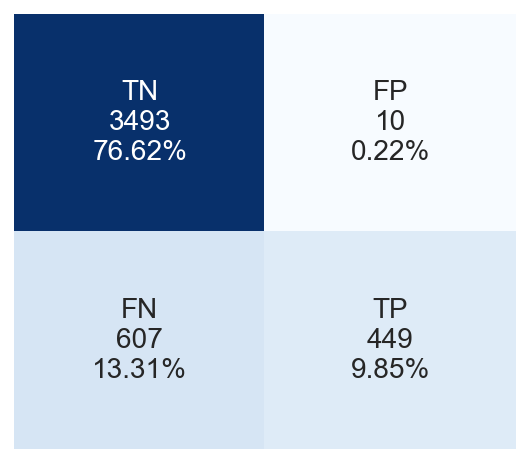

In [59]:
nb2 = MultinomialNB().fit(tfidf_tr2, y_tr2)
y_pr_nb_val2 = nb2.predict(tfidf_val2)
get_metrics_confusion(tfidf_val2, y_val2, y_pr_nb_val2, nb2)

Accuracy:  0.9026102215398114
F1 Score:  0.765079365079365
ROC-AUC:  0.9407687079905536
Recall:  0.6846590909090909
Precision:  0.8669064748201439
PR-AUC:  0.8804737171682502


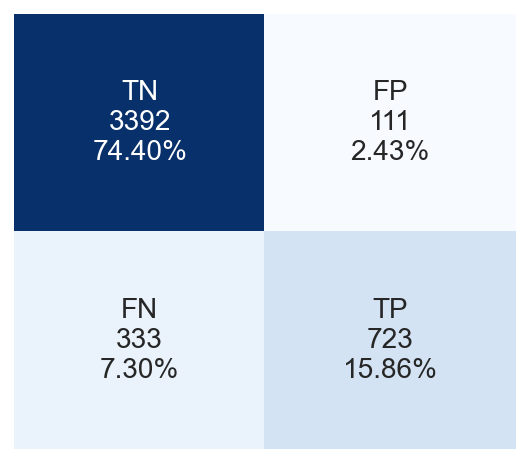

In [60]:
rf2 = RandomForestClassifier(n_estimators=100, random_state=42).fit(tfidf_tr2, y_tr2)
y_pr_rf_val2 = rf2.predict(tfidf_val2)
get_metrics_confusion(tfidf_val2, y_val2, y_pr_rf_val2, rf2)

Accuracy:  0.9098486510199605
F1 Score:  0.7767517653449212
ROC-AUC:  0.9468311523023556
Recall:  0.6770833333333334
Precision:  0.910828025477707
PR-AUC:  0.8936832423461775


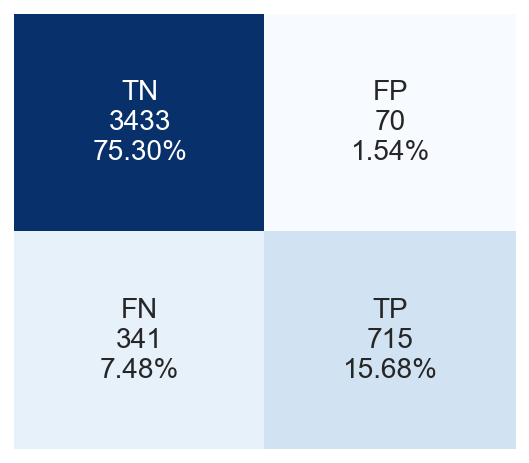

In [61]:
log2 = LogisticRegression(random_state=42).fit(tfidf_tr2, y_tr2)
y_pr_log_val2 = log2.predict(tfidf_val2)
get_metrics_confusion(tfidf_val2, y_val2, y_pr_log_val2, log2)

In [63]:
svc2 = svm.LinearSVC(random_state=42).fit(tfidf_tr2, y_tr2)
y_pr_svc_val2 = svc2.predict(tfidf_val2)
get_metrics_2(tfidf_val2, y_val2, y_pr_svc_val2, svc2)

Accuracy:  0.9080938802368941
F1:  0.7867684478371502
Recall:  0.7320075757575758
Precision:  0.8503850385038504
PR-AUC:  0.8863046292858683


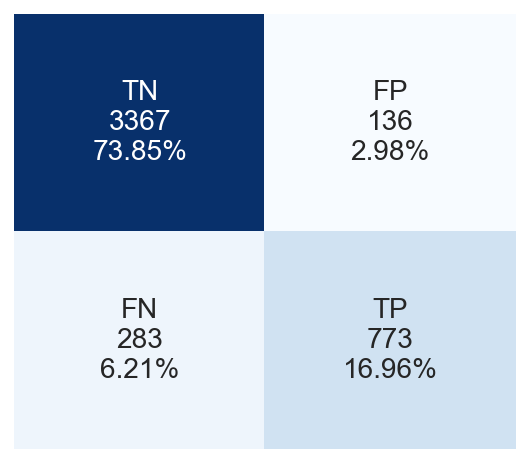

In [64]:
get_confusion(y_val2, y_pr_svc_val2)

Accuracy:  0.88528186005703
F1 Score:  0.7076579094466182
ROC-AUC:  0.9356621543006427
Recall:  0.5994318181818182
Precision:  0.8635743519781719
PR-AUC:  0.8509081977851588


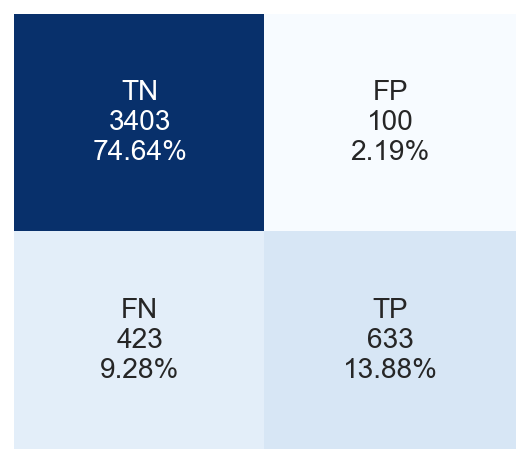

In [65]:
abc2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    random_state=42
    ).fit(tfidf_tr2, y_tr2)
y_pr_ada_val2 = abc2.predict(tfidf_val2)
get_metrics_confusion(tfidf_val2, y_val2, y_pr_ada_val2, abc2)

Accuracy:  0.8743145426628647
F1 Score:  0.6310367031551836
ROC-AUC:  0.9149291137899116
Recall:  0.4640151515151515
Precision:  0.9859154929577465
PR-AUC:  0.7886517579321278


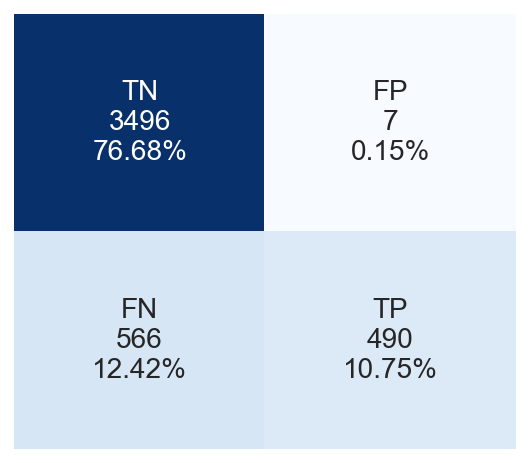

In [66]:
gbc2 = GradientBoostingClassifier(random_state=42).fit(tfidf_tr2, y_tr2)
y_pr_gbc_val2 = gbc2.predict(tfidf_val2)
get_metrics_confusion(tfidf_val2, y_val2, y_pr_gbc_val2, gbc2)

In [69]:
tfidf_val2

<4559x19625 sparse matrix of type '<class 'numpy.float64'>'
	with 28145 stored elements in Compressed Sparse Row format>

In [81]:
metrics5 = pd.read_csv("data/metrics/metrics5.csv", index_col=0)
metrics5

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR AUC
Multinomial Naive Bayes,0.895066,0.819340,0.709677,0.969088,0.939315,0.925620
Random Forest,0.921063,0.877647,0.844369,0.913656,0.963249,0.950887
Logistic Regression,0.924099,0.881517,0.842105,0.924798,0.965593,0.955382
Support Vector Machine,0.919924,0.876464,0.847199,0.907823,0.964879,0.952225
AdaBoost Classifier,0.906452,0.866069,0.902094,0.832811,0.962628,0.936847
Gradient Boosting Classifier,0.876660,0.777550,0.642898,0.983550,0.947051,0.898102


# <a id='7'>Further Modeling</a>

<a href='#0'>Back to top</a>

## <a id='71'>Doc2Vec</a>

In [45]:
train = pickle.load(open("pickle/train.pickle", "rb"))
val = pickle.load(open("pickle/val.pickle", "rb"))
test = pickle.load(open("pickle/test.pickle", "rb"))

In [55]:
train.target.value_counts()

0    17514
1     1072
Name: target, dtype: int64

In [46]:
train['label'] = train.target.apply(lambda x: str(x))
val['label'] = val.target.apply(lambda x: str(x))
test['label'] = test.target.apply(lambda x: str(x))

In [47]:
X_train = train.tweet
X_val = val.tweet
X_test = test.tweet
y_train = train.target
y_val = val.target
y_test = test.target

## DBOW (Distributed Bag of Words)

In [48]:
train_tagged = train.apply(lambda x: TaggedDocument(words=x['tweet'], tags=[str(x.label)]), axis=1)
train_tagged.values[30]

TaggedDocument(words=['retard', 'bruh', 'lol'], tags=['1'])

In [49]:
val_tagged = val.apply(lambda x: TaggedDocument(words=x['tweet'], tags=[str(x.label)]), axis=1)
val_tagged.values[10]

TaggedDocument(words=['twitter', 'fag', 'youre', 'retard'], tags=['1'])

In [50]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 18586/18586 [00:00<00:00, 2376397.21it/s]


In [51]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 18586/18586 [00:00<00:00, 2763687.53it/s]
CPU times: user 18.3 s, sys: 3.16 s, total: 21.4 s
Wall time: 16.8 s


In [53]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_tr_dbow, X_tr_dbow = vec_for_learning(model_dbow, train_tagged)
y_val_dbow, X_val_dbow = vec_for_learning(model_dbow, val_tagged)

In [54]:
logreg = LogisticRegression(n_jobs=1, C=1e5).fit(X_tr_dbow, y_tr_dbow)
y_pred_dbow = logreg.predict(X_val_dbow)

get_metrics_3(X_val_dbow, y_val_dbow, y_pred_dbow, logreg)

Accuracy:  0.937046004842615
F1:  0.1702127659574468
Recall:  0.11214953271028037
Precision:  0.35294117647058826
ROC-AUC:  0.7330152259345128
PR-AUC:  0.22062360214042687


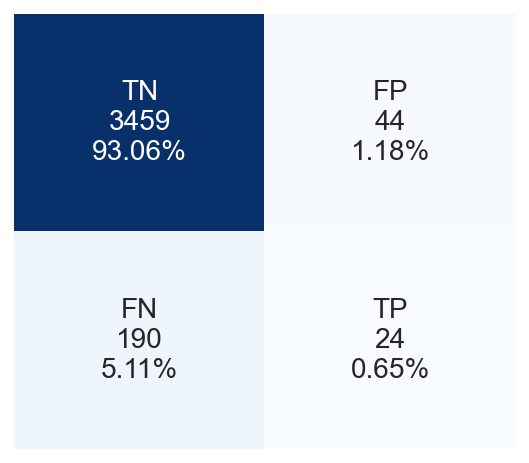

In [55]:
get_confusion(y_val_dbow, y_pred_dbow)

## DMM (Distributed Memory Mean)

In [56]:
cores = multiprocessing.cpu_count()
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=10, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 18586/18586 [00:00<00:00, 2891840.12it/s]


In [57]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 18586/18586 [00:00<00:00, 3001745.64it/s]
CPU times: user 41.5 s, sys: 16.6 s, total: 58.1 s
Wall time: 43.6 s


In [58]:
y_tr_dmm, X_tr_dmm = vec_for_learning(model_dmm, train_tagged)
y_val_dmm, X_val_dmm = vec_for_learning(model_dmm, val_tagged)

logreg_2 = LogisticRegression().fit(X_tr_dmm, y_tr_dmm)
y_pred_dmm = logreg_2.predict(X_val_dmm)

get_metrics_3(X_val_dmm, y_val_dmm, y_pred_dmm, logreg_2)

Accuracy:  0.9171374764595104
F1:  0.28703703703703703
Recall:  0.2897196261682243
Precision:  0.28440366972477066
ROC-AUC:  0.7542440258149891
PR-AUC:  0.22569560150726564


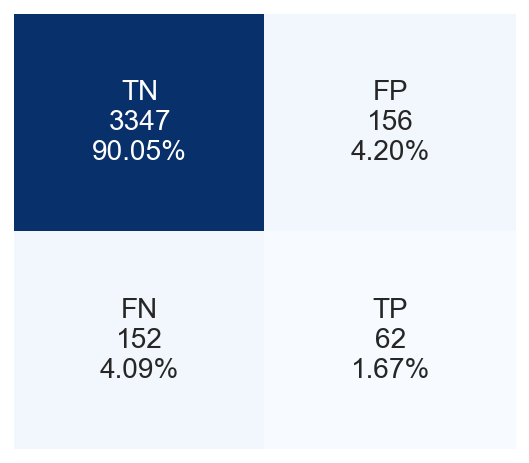

In [59]:
get_confusion(y_val_dmm, y_pred_dmm)